In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import torch
import torchvision
import numpy as np
import nibabel as nib
from typing import Set, List
from skimage import exposure

from sklearn.metrics import auc, roc_curve, average_precision_score, precision_recall_curve
from tqdm import tqdm, trange
from collections import defaultdict
from scipy.stats import multivariate_normal

import oodd
import oodd.models
import oodd.datasets
import oodd.losses
import oodd.evaluators
import oodd.utils
from oodd.layers.likelihoods import grayscale_log_continuous_mix_logistic


np.set_printoptions(suppress=True)
device = torch.device('cuda:1')

mood_brain_dir = '/data/mood/brain/brain_train'
mood_brain_mask_dir = '/data/mood/brain/toy_label/pixel'
mood_brain_toy_dir = '/data/mood/brain/toy'

mood_abdom_dir = '/data/mood/abdom/abdom_train'
mood_abdom_mask_dir = '/data/mood/abdom/toy_label/pixel'
mood_abdom_toy_dir = '/data/mood/abdom/toy'

DEFAULT_FONTSIZE = 13
sns.set_style('white')
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 2,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (7, 7.0 / 1.4),
})


ctx = sns.plotting_context('paper')

In [2]:
def make_strided_patches(img, patch_size=(28, 28), stride=(4, 4), tol=0.1, bg_tol=0.):
    """
    Returns a tuple of patches and coordinates given the a 2D slice of an image an optional 
    patch size and the stride length parameters.
    """
    # For our case of medical images, we discard images that are purely background
    if (img == 0).all():
        return None
    
    
    pipeline = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        oodd.datasets.transforms.PctileChauhan(0.05)
    ])

    def preprocess(arr, pipeline):
        arr = arr.astype('float32')
        return pipeline(arr)
    
    patches = []
    coords = []
    
    x_stride = stride[0]
    y_stride = stride[1]
    
    x_max = img.shape[0]
    y_max = img.shape[1]
    
    n_xstrides = (x_max - patch_size[0]) // x_stride
    n_ystrides = (y_max - patch_size[1]) // y_stride
    for x_stride_num in range(n_xstrides + 1):
        x_cur = x_stride_num * x_stride
        for y_stride_num in range(n_ystrides + 1):
            y_cur = y_stride_num * y_stride
            y2 = y_cur + patch_size[1]
            
            x2 = x_cur + patch_size[0]
            patch = img[x_cur : x2, y_cur: y2]
            if (patch <= bg_tol).sum() <= int(patch_size[0] * patch_size[0] * tol):
                patches.append(preprocess(patch, pipeline))
                coords.append([x_cur, x2, y_cur, y2])
            
    if not patches:
        return None
    
    patches = torch.cat(patches).view(-1, 1, patch_size[0], patch_size[1])
    coords = torch.tensor(coords)
    return patches, coords

def get_nifti(dirname: str, key_words: Set[str] = {}) -> List[str]:
    """
    Return a list of relative file paths to nifti images from the passed
    directory.

    dirname can be relative or absolute.
    """
    walk = os.walk(dirname)
    img_paths = []
    valid_file_types = {'.nii', '.nii.gz'}

    for root, dirs, files in walk:
        for f in files:
            has_kw = all(key_word in f for key_word in key_words)
            
            if (f.endswith('.nii') or f.endswith('.nii.gz')) and has_kw:
                img_paths.append(os.path.join(root, f))
                
    return img_paths

def train_test_split_filenames(dir_or_arr, num_img=None, test_size=0, seed=None, shuffle=True):
    """Creating a train/test split for the file paths of each image"""
    if isinstance(dir_or_arr, str):
        filenames = [os.path.join(dir_or_arr, fn) for fn in os.scandir(dir_or_arr)]
    else:
        filenames = dir_or_arr
    
    if not num_img:
        num_img = len(filenames)
        
    if isinstance(test_size, float):
        train_size = num_img - np.ceil(num_img * test_size).astype(int)
    elif isinstance(test_size, int):
        train_size = num_img - test_size
    else:
        raise TypeError
    
    if shuffle:
        rng = np.random.default_rng(seed=seed)
        rng.shuffle(filenames)
        
    train_paths = filenames[:train_size]
    test_paths = filenames[train_size: num_img]
    
    return train_paths, test_paths

def image_generator(img_paths, tol=0):
    """Loads numpy arrays of images from disk"""
    for path in img_paths:
        img = nib.load(path)
        img_data = img.get_fdata()
        yield img_data, tol
        
def dice(predicted, ground_truth):
    tp = np.sum(predicted & ground_truth)
    fp = np.sum(predicted & (ground_truth != 1))
    fn = np.sum((predicted == 0) & ground_truth)
    dice = 2*tp/(2*tp + fp + fn)
    return dice

In [3]:
#checkpoint_axial = oodd.models.Checkpoint(path='./models/brats_lin_norm_log_mix_10000')

#checkpoint_axial = oodd.models.Checkpoint(path='./models/brats_reg_norm_half')
checkpoint_axial = oodd.models.Checkpoint(path='./models/brats_reg_norm_half_2000_big_latent')
#checkpoint_axial = oodd.models.Checkpoint(path='./models/brats_lin_norm_patches')

#checkpoint_abdom = oodd.models.Checkpoint(path='./models/mood_abdom_10-mix_500-epochs_no-nats_no-cooldown')
#checkpoint_abdom = oodd.models.Checkpoint(path='./models/abdom_axial_small_latent')
#checkpoint_sagittal = oodd.models.Checkpoint(path='./models/mood_brain_sagittal_10-mix_1000-epochs_no-cool_no-nats')
#checkpoint_coronal = oodd.models.Checkpoint(path='./models/mood_brain_coronal_10-mix_1000-epochs_no-cool_no-nats')
#checkpoint_gaussian = oodd.models.Checkpoint(path='./models/mood_brain_axial_gaussian_1000-epochs_1-nat_200-cooldown')
#checkpoint = oodd.models.Checkpoint(path='./models/mood_abdom_10-mix_150-epochs_no-nats_no-cooldown')

checkpoint_axial.load_model()
model_axial = checkpoint_axial.model
model_axial.eval()
model_axial.to(device)

#checkpoint_sagittal.load_model()
#model_sagittal = checkpoint_sagittal.model
#model_sagittal.eval()
#model_sagittal.to(device)
#
#checkpoint_coronal.load_model()
#model_coronal = checkpoint_coronal.model
#model_coronal.eval()
#model_coronal.to(device)
#
#checkpoint_abdom.load_model()
#model_abdom = checkpoint_abdom.model
#model_abdom.eval()
#model_abdom.to(device)
#
#checkpoint_gaussian.load_model()
#model_gaussian = checkpoint_gaussian.model
#model_gaussian.eval()
#model_gaussian.to(device)

#models = {'axial': model_axial, 'sagittal': model_sagittal, 'coronal': model_coronal}
models = {'axial': model_axial}
#models_abdom = {'axial': model_abdom}
criterion = oodd.losses.ELBO()

In [4]:
dirname = '/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/'
brats_2018_paths = get_nifti(dirname, key_words={'flair'})
brats_2018_seg_paths = get_nifti(dirname, key_words={'seg'})

train_fn, val_fn = train_test_split_filenames(
    brats_2018_paths, test_size=0.1, shuffle=True, seed=11)
seg_train_fn, seg_val_fn = train_test_split_filenames(
    brats_2018_seg_paths, test_size=0.1, shuffle=True, seed=11)

In [5]:
brats_val_imgs = image_generator(val_fn)
brats_val_segs = image_generator(seg_val_fn)

In [6]:
brats_img, _ = next(brats_val_imgs)
brats_seg, _ = next(brats_val_segs)

In [7]:
brats_img1, _ = next(brats_val_imgs)
brats_seg1, _ = next(brats_val_segs)

In [8]:
brats_img2, _ = next(brats_val_imgs)
brats_seg2, _ = next(brats_val_segs)

(array([ 12848.,  39422.,  49580.,  52410.,  75784., 179005., 317358.,
        298459., 183313.,  81041.,  37268.,  21198.,  13448.,   9274.,
          6868.,   5003.,   3941.,   3214.,   2475.,   2078.,   1893.,
          1556.,   1389.,   1295.,   1058.,    961.,    933.,    695.,
           688.,    614.,    498.,    473.,    427.,    343.,    277.,
           227.,    163.,    135.,    136.,     77.,     57.,     38.,
            24.,     12.,     11.,      6.,      4.,      5.,      0.,
             1.]),
 array([   1.  ,   27.34,   53.68,   80.02,  106.36,  132.7 ,  159.04,
         185.38,  211.72,  238.06,  264.4 ,  290.74,  317.08,  343.42,
         369.76,  396.1 ,  422.44,  448.78,  475.12,  501.46,  527.8 ,
         554.14,  580.48,  606.82,  633.16,  659.5 ,  685.84,  712.18,
         738.52,  764.86,  791.2 ,  817.54,  843.88,  870.22,  896.56,
         922.9 ,  949.24,  975.58, 1001.92, 1028.26, 1054.6 , 1080.94,
        1107.28, 1133.62, 1159.96, 1186.3 , 1212.64, 1238.

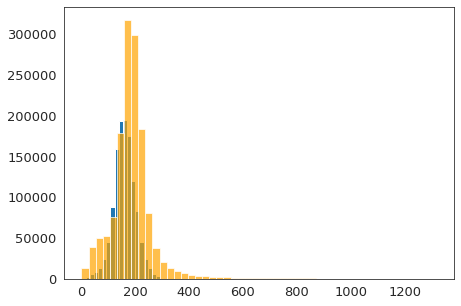

In [345]:
plt.hist(brats_img1.ravel()[(brats_img1.ravel() > 0) & (brats_seg1.ravel() == 0)], bins=50)
plt.hist(brats_img2.ravel()[(brats_img2.ravel() > 0) & (brats_seg2.ravel() == 0)], color='orange', alpha=0.7, bins=50)

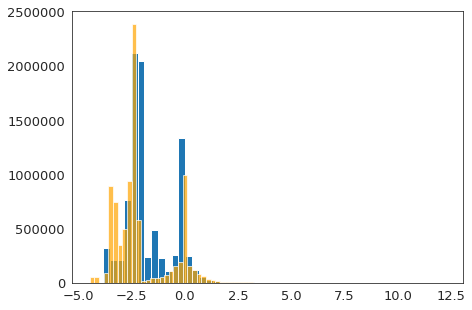

In [10]:
mx_1 = brats_img1.max(axis=(0, 1))
mask_1 = np.ma.masked_array(brats_img1, mask=brats_img1 == 0)
mu_1 = mask_1.mean(axis=(0, 1))
stdev_1 = mask_1.std(axis=(0, 1))
#scaled_img1 = brats_img1 / np.where(mx_1 == 0, 1, mx_1)
scaled_img1 = (brats_img1 - mu_1) / stdev_1

mx_2 = brats_img2.max(axis=(0, 1))
mask_2 = np.ma.masked_array(brats_img2, mask=brats_img2 == 0)
mu_2 = mask_2.mean(axis=(0, 1))
stdev_2 = mask_2.std(axis=(0, 1))

#scaled_img2 = brats_img2 / np.where(mx_2 == 0, 1, mx_2)
scaled_img2 = (brats_img2 - mu_2) / stdev_2

h = plt.hist(scaled_img1.ravel()[(scaled_img1.ravel() > -20) & (brats_seg1.ravel() == 0)], bins=50)
h = plt.hist(scaled_img2.ravel()[(scaled_img2.ravel() > -20) & (brats_seg1.ravel() == 0)], color='orange', alpha=0.7, bins=50)

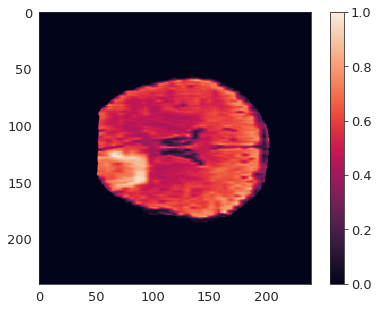

In [265]:
brats_slice = brats_img1[:, :, 89]

brats_slice = (brats_slice / brats_slice.max())
plt.imshow(brats_slice)
plt.colorbar()

In [65]:
np.ma.masked_array(brats_slice, mask=(brats_slice == 0)).min()

0.0014925373134328358

array([0., 1., 2., 4.])

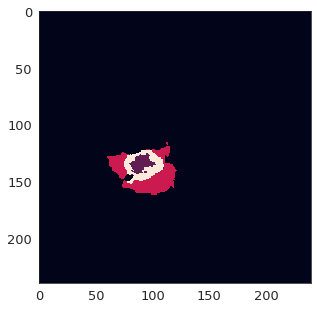

In [13]:
brats_slice_seg = brats_seg[:, :, 89]
plt.imshow(brats_slice_seg)
np.unique(brats_slice_seg)

In [14]:
brats_img, _ = next(brats_val_imgs)
brats_seg, _ = next(brats_val_segs)

### Patches Model

In [15]:
iw_samples_elbo = 1
iw_samples_Lk = 1
batch_size = 256
n_latents_skip = 2
n_eval_examples = float("inf")

brain_name = 'brats'
brain = brats_img[:, :, 89:93]


#x_inds, y_inds = np.indices((28, 28)) - 14
#weight_mask = 1 - (np.sqrt(x_inds**2 + y_inds ** 2) / 28)

#mv_norm = multivariate_normal(mean=[0, 0], cov=np.eye(2)*60)
#peak = mv_norm.pdf([0, 0])
#weight_mask = mv_norm.pdf(np.c_[x_inds.ravel(), y_inds.ravel()]).reshape(28, 28) / peak

SCORES = defaultdict(list)
COMP_SCORES = defaultdict(list)

def get_decode_from_p(n_latents, k=0, semantic_k=True):
    """
    k semantic out
    0 True     [False, False, False]
    1 True     [True, False, False]
    2 True     [True, True, False]
    0 False    [True, True, True]
    1 False    [False, True, True]
    2 False    [False, False, True]
    """
    if semantic_k:
        return [True] * k + [False] * (n_latents - k)

    return [False] * (k + 1) + [True] * (n_latents - k - 1)

def get_lengths(dataloaders):
    return [len(loader) for name, loader in dataloaders.items()]

voxel_scores = []
means = []
stride = (4, 4)
tol = 0
bg_tol = 0

for plane in models:
    model = models[plane]
    
    score_mask = np.full(brain.shape, 0., dtype='float32')
    #score_mask = np.full((512, 512, 512), 0., dtype='float32')
    #score_mask = np.full((256, 256, 256, 50), 0., dtype='float32')
    #score_mask = np.empty((256, 256, 256, 50), dtype='object')
    #for i, row in enumerate(score_mask):
    #    for j, col in enumerate(row):
    #        for z, width in enumerate(col):
    #            score_mask[i, j, z] = []
    #mean_mask = np.full((512, 512, 512), 0.)
    mean_mask = np.full(brain.shape, 0.)
    
    for z in trange(brain.shape[-1]):
        if plane == 'axial':
            strided_patches = make_strided_patches(brain[:, :, z], stride=stride, tol=tol, bg_tol=bg_tol)
        elif plane == 'sagittal':
            strided_patches = make_strided_patches(brain[z, :, :], stride=stride, tol=tol, bg_tol=bg_tol)
        elif plane == 'coronal':
            strided_patches = make_strided_patches(brain[:, z, :], stride=stride, tol=tol, bg_tol=bg_tol)
        if strided_patches:
            stride_gen, coords = strided_patches 
        else:
            continue
        dataset = torch.utils.data.TensorDataset(stride_gen, coords)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

        #n_test_batches = get_lengths(datamodule.val_datasets) + get_lengths(datamodule.test_datasets)
        #N_EQUAL_EXAMPLES_CAP = min(n_test_batches)
        #assert N_EQUAL_EXAMPLES_CAP % batch_size == 0, "Batch size must divide smallest dataset size"
        #N_EQUAL_EXAMPLES_CAP = min([n_eval_examples, N_EQUAL_EXAMPLES_CAP])

        decode_from_p = get_decode_from_p(model.n_latents, k=n_latents_skip)
        comp_decode_from_p = get_decode_from_p(model.n_latents, k=1, semantic_k=False)

        scores = defaultdict(list)
        elbos = defaultdict(list)
        elbos_k = defaultdict(list)
        elbos_l = defaultdict(list)
        gen_llr_scores = defaultdict(list)
        with torch.no_grad():
            n = 0
            for b, (x, coord) in enumerate(loader):
                x = x.to(device)
                n += x.shape[0]
                sample_elbos, sample_elbos_k, sample_elbos_l = [], [], []

                # Regular ELBO
                for i in range(iw_samples_elbo):
                    likelihood_data, stage_datas = model(x, decode_from_p=False, use_mode=False)
                    kl_divergences = [
                        stage_data.loss.kl_elementwise
                        for stage_data in stage_datas
                        if stage_data.loss.kl_elementwise is not None
                    ]
                    loss, elbo, likelihood, kl_divergences = criterion(
                        likelihood_data.likelihood,
                        kl_divergences,
                        samples=1,
                        free_nats=0,
                        beta=1,
                        sample_reduction=None,
                        batch_reduction=None,
                    )
                    sample_elbos.append(elbo.detach())

                # L>k bound
                for i in range(iw_samples_Lk):
                    likelihood_data_k, stage_datas_k = model(x, decode_from_p=decode_from_p, use_mode=decode_from_p)
                    kl_divergences_k = [
                        stage_data.loss.kl_elementwise
                        for stage_data in stage_datas_k
                        if stage_data.loss.kl_elementwise is not None
                    ]
                    loss_k, elbo_k, likelihood_k, kl_divergences_k = criterion(
                        likelihood_data_k.likelihood,
                        kl_divergences_k,
                        samples=1,
                        free_nats=0,
                        beta=1,
                        sample_reduction=None,
                        batch_reduction=None,
                    )
                    sample_elbos_k.append(elbo_k.detach())
                    
                # L>l bound
                for i in range(iw_samples_Lk):
                    likelihood_data_l, stage_datas_l = model(x, decode_from_p=comp_decode_from_p, use_mode=comp_decode_from_p)
                    kl_divergences_l = [
                        stage_data.loss.kl_elementwise
                        for stage_data in stage_datas_l
                        if stage_data.loss.kl_elementwise is not None
                    ]
                    loss_l, elbo_l, likelihood_l, kl_divergences_l = criterion(
                        likelihood_data_l.likelihood,
                        kl_divergences_l,
                        samples=1,
                        free_nats=0,
                        beta=1,
                        sample_reduction=None,
                        batch_reduction=None,
                    )
                    sample_elbos_l.append(elbo_k.detach())

                sample_elbos = torch.stack(sample_elbos, axis=0)
                sample_elbos_k = torch.stack(sample_elbos_k, axis=0)
                sample_elbos_l = torch.stack(sample_elbos_l, axis=0)

                sample_elbo = oodd.utils.log_sum_exp(sample_elbos, axis=0)
                sample_elbo_k = oodd.utils.log_sum_exp(sample_elbos_k, axis=0)
                sample_elbo_l = oodd.utils.log_sum_exp(sample_elbos_l, axis=0)

                score = sample_elbo - sample_elbo_k
                gen_llr_score = sample_elbo_l - sample_elbo_k

                for ind, (x1, x2, y1, y2) in enumerate(coord):
                    if plane == 'axial':
                        score_mask[x1:x2, y1:y2, z] += score[ind].detach().cpu().numpy()
                        mean_mask[x1:x2, y1:y2, z] += 1
                    elif plane == 'sagittal':
                        score_mask[z, x1:x2, y1:y2] += score[ind].detach().cpu().numpy()
                        mean_mask[z, x1:x2, y1:y2] += 1
                    elif plane == 'coronal':
                        score_mask[x1:x2, z, y1:y2] += score[ind].detach().cpu().numpy()
                        mean_mask[x1:x2, z, y1:y2] += 1

                    #score_mask[x1:x2, y1:y2] += weight_mask * score[ind].detach().cpu().numpy()
                    #mean_mask[x1:x2, y1:y2] += weight_mask

                    #patch_score = score[ind].detach().cpu().numpy()
                    #score_slice = score_mask[x1:x2, y1:y2, z]

                    #for row in pixel_lists:
                    #    for col in row:
                    #        col.append(patch_score)
                    #score_slice[np.nonzero(pixel_lists)] = patch_score
                    #score_slice[:, :, np.argmax(score_slice == 0, axis=-1)] = patch_score

                scores[brain_name].extend(score.tolist())
                elbos[brain_name].extend(sample_elbo.tolist())
                elbos_k[brain_name].extend(sample_elbo_k.tolist())
                elbos_l[brain_name].extend(sample_elbo_l.tolist())
                gen_llr_scores[brain_name].extend(gen_llr_score.tolist())

        SCORES[brain_name].extend(scores[brain_name])
        COMP_SCORES[brain_name].extend(gen_llr_scores[brain_name])
    means.append(mean_mask)
    voxel_scores.append(score_mask)

  0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 4, 5, 5], expected input[256, 1, 28, 28] to have 4 channels, but got 1 channels instead

<ipython-input-192-215c7e9b75c9>:1: RuntimeWarning: invalid value encountered in divide
  per_pixel_map_axial = voxel_scores[0] / means[0]


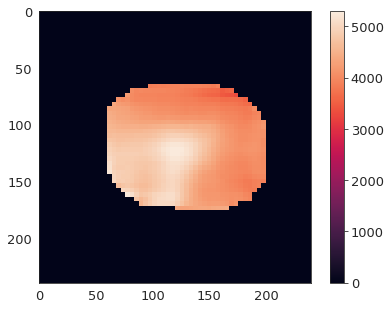

In [192]:
per_pixel_map_axial = voxel_scores[0] / means[0]
per_pixel_map_axial = np.where(np.isnan(per_pixel_map_axial), 0, per_pixel_map_axial)
#plt.imshow(per_pixel_map_axial[:, :, 89])
plt.imshow(per_pixel_map_axial[:, :, 2])
plt.colorbar()

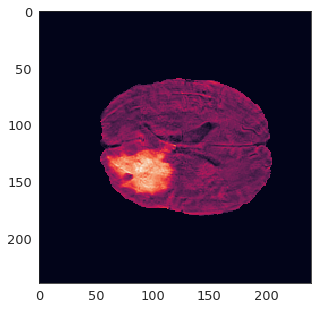

In [193]:
plt.imshow(brats_img[:, :, 89])

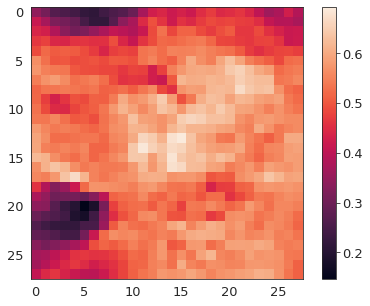

In [233]:
anom_patch = brats_img[125:125+28, 75:75+28, 89]
plt.imshow(anom_patch)

with torch.no_grad():
    inp = torch.tensor(anom_patch.astype('float32'), device=device).unsqueeze(0).unsqueeze(0)
    ll, stage = models['axial'](inp, decode_from_p=[True, True, False])
plt.colorbar()

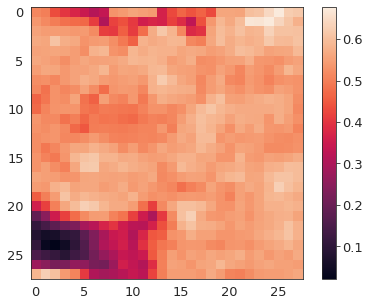

In [234]:
plt.imshow(ll.mean.cpu().squeeze())
plt.colorbar()

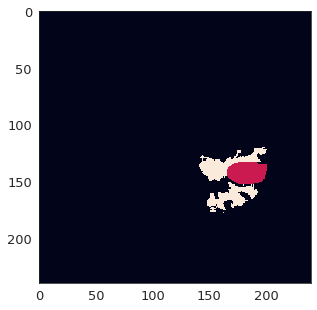

In [333]:
plt.imshow(brats_seg[:, :, 90])

In [334]:
plt.hist(per_pixel_map_axial[:, :, 78].ravel()[(per_pixel_map_axial[:, :, 78] > 6650).ravel()])

IndexError: index 78 is out of bounds for axis 2 with size 4

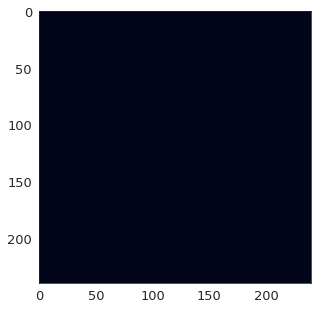

In [335]:
#plt.imshow((per_pixel_map_axial[:, :, 0] > 6000) & (brats_seg[:, :, 89] != 0))
plt.imshow((per_pixel_map_axial[:, :, 0] > 7250))

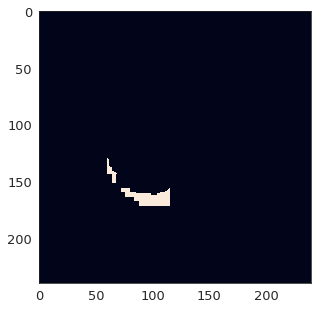

In [268]:
plt.imshow((per_pixel_map_axial[:, :, 0] > 6600) & (brats_seg[:, :, 89] == 0))

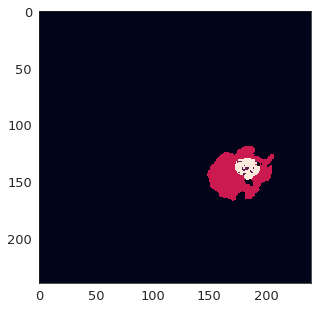

In [287]:
plt.imshow(brats_seg[:, :, 89])

(array([368., 160., 288., 192., 336., 448., 944., 528., 400., 176.]),
 array([6101.40178571, 6172.71922433, 6244.03666295, 6315.35410156,
        6386.67154018, 6457.98897879, 6529.30641741, 6600.62385603,
        6671.94129464, 6743.25873326, 6814.57617188]),
 <a list of 10 Patch objects>)

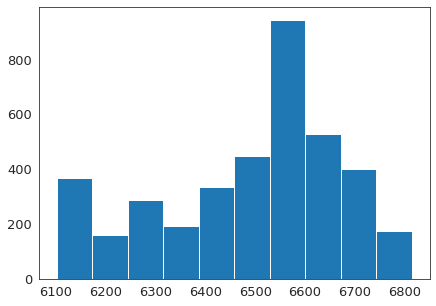

In [77]:
plt.hist(per_pixel_map_axial[:, :, 89].ravel()[(per_pixel_map_axial[:, :, 89] > 6100).ravel()])

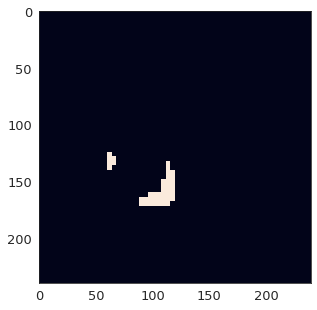

In [29]:
plt.imshow(per_pixel_map_axial[:, :, 0]> 6000)

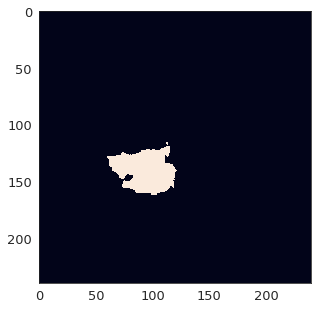

In [16]:
plt.imshow(brats_seg[:, :, 89] != 0)

In [352]:
predicted = per_pixel_map_axial
bool_preds = np.full(predicted.shape, False)
ground = (brats_seg[:, :, 89:93] != 0)


for sl in range(predicted.shape[-1]):
    pred_slice = predicted[:, :, sl]
    gt_slice = ground[:, :, sl]
    freq, bins = np.histogram(pred_slice.ravel()[pred_slice.ravel() > 6200], bins=5)
    if not (freq == 0).all():
        max_bin = bins[np.argmax(freq)]
        thresholded_slice = pred_slice > max_bin
        print(sl, dice(thresholded_slice, ground[:, :, sl]))
        bool_preds[:, :, sl] = thresholded_slice

0 0.7574269005847953
1 0.7815715622076708
2 0.7613753345686638
3 0.6792156862745098


In [251]:
for sl in range(predicted.shape[-1]):
    pred_slice = predicted[:, :, sl]
    gt_slice = ground[:, :, sl]
    print(sl, dice(pred_slice > 6250, ground[:, :, sl]))

0 0.38070175438596493
1 0.33935018050541516
2 0.2887128712871287
3 0.30367667695761996


In [353]:
dice(bool_preds, ground)

0.742489734169008

In [117]:
brats_seg.shape

(240, 240, 155)

In [75]:
predicted = (per_pixel_map_axial[:, :, 89] > 6450) 
ground = (brats_slice_seg != 0)

dice(predicted, ground)
#average_precision_score(predicted.ravel(), ground.ravel())

0.7621052631578947

In [55]:
average_precision_score(bool_preds.ravel(), ground.ravel())

0.4153438918325161

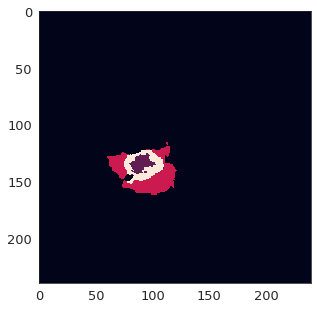

In [33]:
plt.imshow(brats_slice_seg)

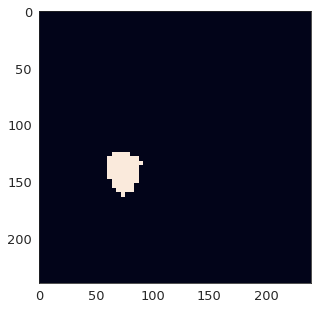

In [53]:
plt.imshow(per_pixel_map_axial[:, :, 78] > 6300)

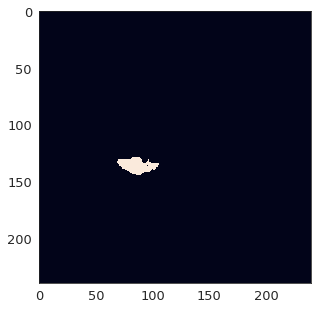

In [243]:
plt.imshow(brats_seg[:, :, 78])

### Brats Full Subvolumes

In [5]:
dirname = '/data/BraTS2018/MICCAI_BraTS_2018_Data_Training/'
brats_2018_paths = get_nifti(dirname, key_words={'flair'})
brats_2018_seg_paths = get_nifti(dirname, key_words={'seg'})

model_chkpt = oodd.models.Checkpoint(path='./models/brats_lin_norm_log_mix_10000')
model_chkpt.load_model()
model = model_chkpt.model
model.to(device)
model.eval()

train_fn, val_fn = train_test_split_filenames(
    brats_2018_paths, test_size=0.1, shuffle=True, seed=11)
seg_train_fn, seg_val_fn = train_test_split_filenames(
    brats_2018_seg_paths, test_size=0.1, shuffle=True, seed=11)

In [7]:
brats_val_imgs = image_generator(val_fn)
brats_val_segs = image_generator(seg_val_fn)

brats_img, _ = next(brats_val_imgs)
brats_img = brats_img / brats_img.max() # hacky normalization
brats_seg, _ = next(brats_val_segs)

In [17]:
# Computing the reconstructions of validation subvolumes
recons = []
with torch.no_grad():
    for _ in range(16):
        center_crop = torchvision.transforms.CenterCrop((224, 224))
        x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
        x = center_crop(x).unsqueeze(0)
        ll, stage = model(x, decode_from_p=[False, False, False, False])
        recons.append(ll.mean.cpu().permute(0, 2, 3, 1))

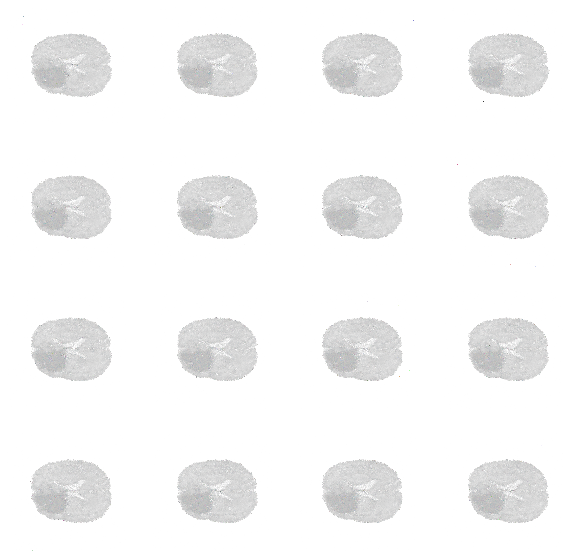

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(recons[i].squeeze())
    ax.axis('off')

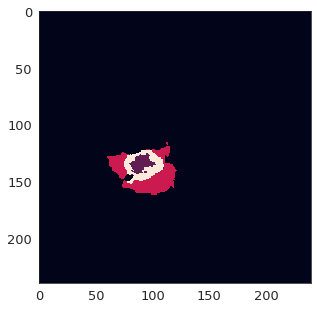

In [19]:
plt.imshow(brats_seg[:, :, 89])

In [20]:
with torch.no_grad():
    center_crop = torchvision.transforms.CenterCrop((224, 224))
    x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
    x = center_crop(x).unsqueeze(0)
    ll, stage = model(x)
print(ll.likelihood)

tensor([927342.8750], device='cuda:1')


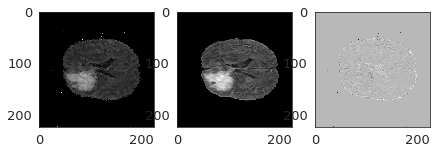

In [21]:
fig, ax = plt.subplots(1, 3)
recon = ll.mean.cpu().squeeze().permute(1, 2, 0)
ground = x.cpu().squeeze().permute(1, 2, 0)

im1 = ax[0].imshow(recon[:, :, 0], cmap='gray')
im2 = ax[1].imshow(ground[:, :, 0], cmap='gray')
im3 = ax[2].imshow(ground[:, :, 0] - recon[:, :, 0], cmap='gray')

#plt.colorbar(im1, ax=ax[0])
#plt.colorbar(im2, ax=ax[1])
#plt.colorbar(im3, ax=ax[2])

In [22]:
recons = []
with torch.no_grad():
    for _ in range(1000):
        center_crop = torchvision.transforms.CenterCrop((224, 224))
        x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
        x = center_crop(x).unsqueeze(0)
        ll, stage = model(x, decode_from_p=[True, False, False, False])
        recons.append(ll.mean.cpu().permute(0, 2, 3, 1))

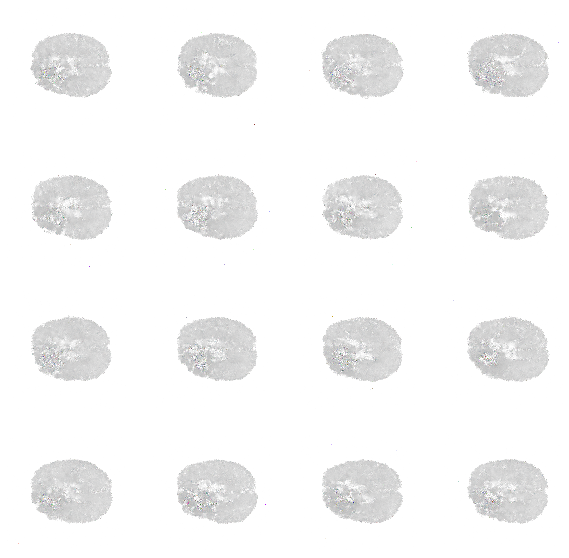

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(recons[i].squeeze())
    ax.axis('off')

In [24]:
recons = []
with torch.no_grad():
    for _ in range(16):
        center_crop = torchvision.transforms.CenterCrop((224, 224))
        x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
        x = center_crop(x).unsqueeze(0)
        ll, stage = model(x, decode_from_p=[False, True, False, False])
        recons.append(ll.mean.cpu().permute(0, 2, 3, 1))

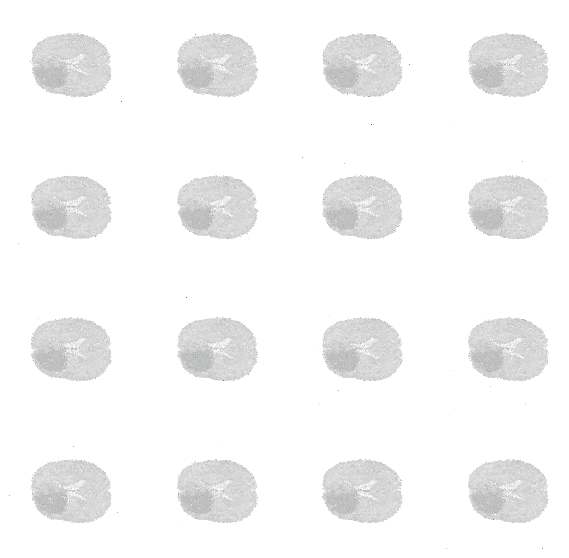

In [25]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(recons[i].squeeze())
    ax.axis('off')

In [26]:
ll.likelihood

tensor([927217.5000], device='cuda:1')

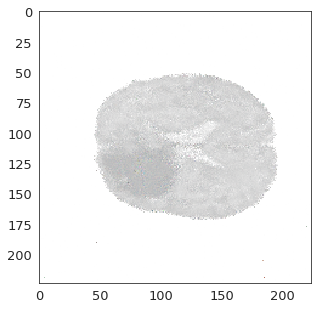

In [27]:
plt.imshow(ll.mean.cpu().squeeze().permute(1, 2, 0))

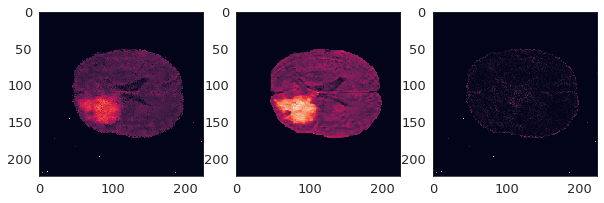

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
recon = ll.mean.cpu().squeeze().permute(1, 2, 0)
ground = x.cpu().squeeze().permute(1, 2, 0)

im1 = ax[0].imshow(recon[:, :, 0])
im2 = ax[1].imshow(ground[:, :, 0])
im3 = ax[2].imshow(np.abs(ground[:, :, 0] - recon[:, :, 0]))

#plt.colorbar(im1, ax=ax[0])
#plt.colorbar(im2, ax=ax[1])
#plt.colorbar(im3, ax=ax[2])

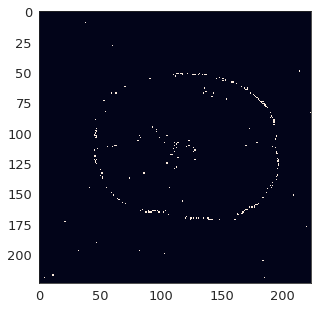

In [29]:
plt.imshow(np.abs(ground[:, :, 0] - recon[:, :, 0]) > 0.2)
#plt.colorbar()

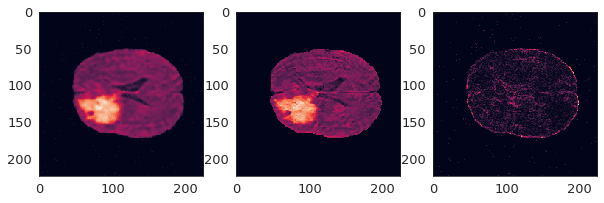

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
recon = torch.concatenate(recons, 0).mean(axis=0)
ground = x.cpu().squeeze().permute(1, 2, 0)

im1 = ax[0].imshow(recon[:, :, 0])
im2 = ax[1].imshow(ground[:, :, 0])
im3 = ax[2].imshow(np.abs(ground[:, :, 0] - recon[:, :, 0]))

#plt.colorbar(im1, ax=ax[0])
#plt.colorbar(im2, ax=ax[1])
#plt.colorbar(im3, ax=ax[2])

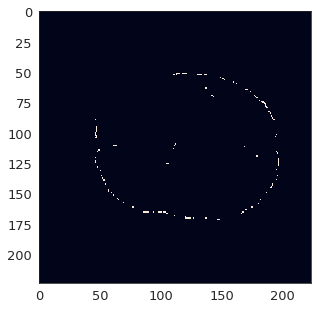

In [31]:
plt.imshow(np.abs(ground[:, :, 0] - recon[:, :, 0]) > 0.15)

### Displaying Multiple Reconstructions of z>i Of Different Images For Full Subvolumes

In [71]:
recons_by_latents = []
brats_val_imgs = image_generator(val_fn)
brats_val_segs = image_generator(seg_val_fn)

# brats_seg, _ = next(brats_val_segs)

with torch.no_grad():
    for _ in range(4):
        brats_img, _ = next(brats_val_imgs)
        brats_img = brats_img / brats_img.max() # hacky normalization
        x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
        x = center_crop(x).unsqueeze(0)
        recons_by_latents.append(x.cpu().permute(0, 2, 3, 1).numpy())
        
        for i in range(5):
            center_crop = torchvision.transforms.CenterCrop((224, 224))
            ll, stage = model(x, decode_from_p=([True] * i) + ([False] * (4 - i)))
            recons_by_latents.append(ll.mean.cpu().permute(0, 2, 3, 1).numpy())

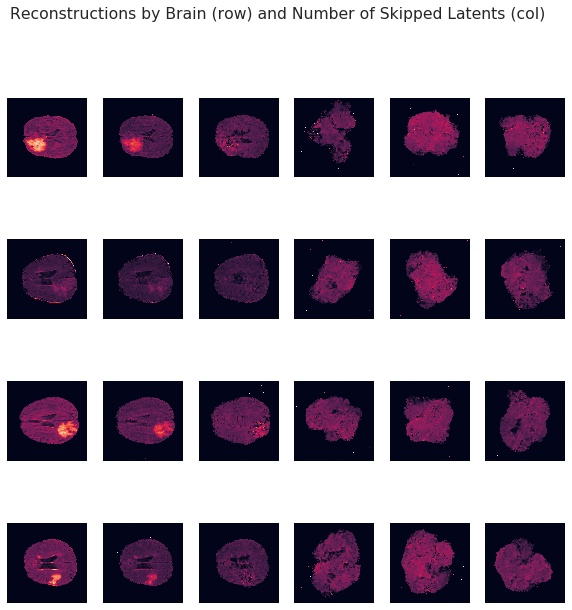

In [72]:
fig, axes = plt.subplots(4, 6, figsize=(10, 10))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(recons_by_latents[i][0, :, :, 0])
    ax.axis('off')
    
s = fig.suptitle("Reconstructions by Brain (row) and Number of Skipped Latents (col)")

In [68]:
recons_by_latents[0].shape

(1, 224, 224, 4)

### Brats Half Subvolume

In [4]:
dirname = '/data/BraTS2018/BraTS18_Training_norm/'
seg_dirname = '/data/BraTS2018/BraTS18_Training_norm/'
brats_2018_paths = sorted(get_nifti(dirname, key_words={'flair_Warped'}))
brats_2018_seg_paths = sorted(get_nifti(seg_dirname, key_words={'seg'}), key=lambda f: f.split('/')[-1])

random.seed(11)
path_pairs = list(zip(brats_2018_paths, brats_2018_seg_paths))
segs = [seg for _, seg in path_pairs]
imgs = [train for train, _ in path_pairs]

train_size = int(len(imgs) - np.ceil(0.1 * len(imgs)))

train_fn = imgs[:train_size]
seg_train_fn = segs[:train_size]
val_fn = imgs[train_size:]
seg_val_fn = segs[train_size:]

In [5]:
brats_val_imgs = image_generator(val_fn)
brats_val_segs = image_generator(seg_val_fn)

In [6]:
brats_img, _ = next(brats_val_imgs)
brats_img = brats_img / brats_img.max()
brats_seg, _ = next(brats_val_segs)

In [7]:
recons = []
model = models['axial']

center_crop = torchvision.transforms.CenterCrop((224, 224))
#subvolume = central_crop(torch.tensor(np.expand_dims(subvolume[:, :, s], 0))).permute(1, 2, 0)
x = torch.tensor(brats_img[:, :, 89:93].astype('float32'), device=device).permute(2, 0, 1)
x = center_crop(x).unsqueeze(0)
        
with torch.no_grad():
    for _ in range(100):
        x_top = x[:, :, :224//2, :]
        x_bot = x[:, :, 224//2:, :]
        ll_top, stage_top = model(x_top, decode_from_p=[True, False, False, False])
        ll_bot, stage_bot = model(x_bot, decode_from_p=[True, False, False, False])
        
        recons.append(torch.concatenate([ll_top.mean, ll_bot.mean], dim=2).cpu().permute(0, 2, 3, 1))

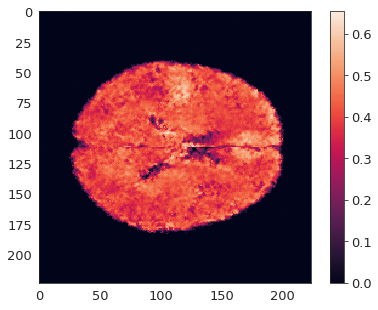

In [8]:
plt.imshow(recons[1].squeeze().cpu()[:, :, 0])
plt.colorbar()

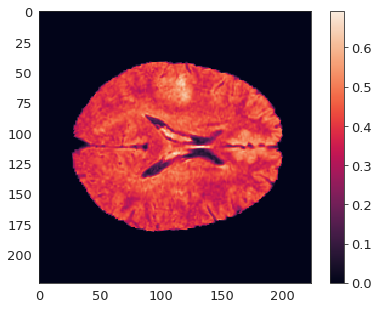

In [9]:
plt.imshow(x[:, 2, :, :].cpu().squeeze())
plt.colorbar()

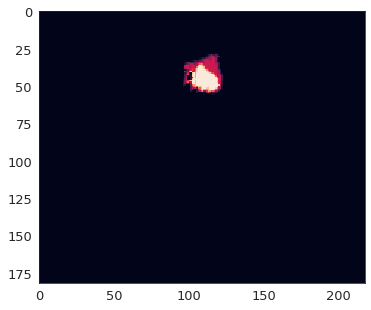

In [10]:
plt.imshow(brats_seg[:, :, 91])

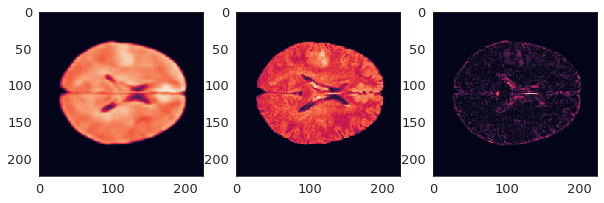

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
recon = torch.concatenate(recons, 0).mean(axis=0)
ground = x.cpu().squeeze().permute(1, 2, 0)

im1 = ax[0].imshow(recon[:, :, 2])
im2 = ax[1].imshow(ground[:, :, 2])
im3 = ax[2].imshow(np.abs(ground[:, :, 2] - recon[:, :, 2]))

#plt.colorbar(im1, ax=ax[0])
#plt.colorbar(im2, ax=ax[1])
#plt.colorbar(im3, ax=ax[2])

In [ ]:
# Displaying reconstructions of anomalous brains
